In [245]:
!pip install transformers sentencepiece nbformat nltk protobuf timm
!pip install ftfy regex tqdm matplotlib opencv-python scipy scikit-image
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to c:\users\arash\appdata\local\temp\pip-req-build-kpse2ejk
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\arash\AppData\Local\Temp\pip-req-build-kpse2ejk'


In [25]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import numpy as np
from transformers import (
    T5Tokenizer, T5ForConditionalGeneration, MBartForConditionalGeneration, 
    MBart50TokenizerFast, BertTokenizer, AutoTokenizer, AutoModel, 
    AutoModelForSeq2SeqLM, BlipProcessor, BlipForConditionalGeneration, 
    ViTModel, ViTFeatureExtractor, ViTConfig, DetrImageProcessor, 
    DetrForObjectDetection
)
import torch
import pandas as pd
import clip
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import numpy as np
import plotly.express as px
from bertviz import model_view
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import plotly.io as pio
import re
import clip
import nltk
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from bertviz import head_view
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from IPython.display import display
from scipy.ndimage import filters
import torch.nn.functional as F
import cv2
from skimage import transform as skimage_transform
import timm
from functools import partial
from models.vit import VisionTransformer
from models.xbert import BertConfig, BertModel
from utils.viz_model_utils import VLTransformerITM, pre_caption, transform
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors
import random
from PIL import Image
import base64
from io import BytesIO
# pio.renderers.default = 'browser'
pio.renderers.default = 'vscode'

nltk.download('stopwords')
english_stop_words = set(stopwords.words('english'))
french_stop_words = set(stopwords.words('french'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [127]:
def clean_token(token, language='english'):
    token = re.sub(r'[^A-Za-z0-9]+', '', token)
    if language == 'french':
        unwanted_tokens = {'s', 'pad', 'unk', 'cls', 'sep', 'mask', 'en_xx', 'enXX', 'fr_xx', 'frxx', 'enxx', 'frxx'}
        if token.lower() in french_stop_words or token.lower() in unwanted_tokens or token == '':
            return None
    else:
        unwanted_tokens = {'s', 'pad', 'unk', 'cls', 'sep', 'mask', 'en_xx', 'enxx', 'fr_xx', 'frxx', 'enxx', 'frxx'}
        if token.lower() in english_stop_words or token.lower() in unwanted_tokens or token == '':
            return None
    return token

In [128]:
def filter_tokens_embeddings(src_embeddings, src_tokens, language='english'):
    cleaned_src_tokens = [clean_token(token, language=language) for token in src_tokens if clean_token(token, language=language) is not None]
    filtered_src_embeddings = [src_embeddings[i] for i in range(len(src_tokens)) if clean_token(src_tokens[i], language=language) is not None]
    return filtered_src_embeddings, cleaned_src_tokens

In [129]:
def compute_cosine_similarity(target_embedding, embeddings):
    return cosine_similarity([target_embedding], embeddings)[0]

In [130]:
def create_3d_cosine_plot(input_text, target_word, title, language='english'):
    # Step 1: Tokenize the source text
    src_input_ids, src_tokens = tokenize_text(input_text)

    # Ensure both input text and target word are lowercased
    input_text = input_text.lower()
    target_word = target_word.lower()

    # Step 2: Extract embeddings from the tokenized inputs
    src_embeddings = extract_embeddings(src_input_ids)

    # Filter and clean tokens and embeddings
    filtered_embeddings, cleaned_tokens = filter_tokens_embeddings(src_embeddings, src_tokens, language=language)

    # Find the index of the target word
    if target_word not in cleaned_tokens:
        raise ValueError(f"The target word '{target_word}' was not found in the provided tokens.")
    
    target_idx = cleaned_tokens.index(target_word)
    target_embedding = filtered_embeddings[target_idx]

    # Compute cosine similarities with all words
    cosine_similarities = compute_cosine_similarity(target_embedding, filtered_embeddings)

    # Sort the tokens and cosine similarities in descending order
    sorted_indices = np.argsort(cosine_similarities)[::-1]
    sorted_tokens = [cleaned_tokens[i] for i in sorted_indices]
    sorted_similarities = [cosine_similarities[i] for i in sorted_indices]

    # Normalize cosine similarities for color scale mapping
    max_sim = max(sorted_similarities)
    min_sim = min(sorted_similarities)
    normalized_sims = [(sim - min_sim) / (max_sim - min_sim) for sim in sorted_similarities]

    # Create the bar chart for cosine similarity using a color scale (Viridis)
    fig = go.Figure()

    fig.add_trace(go.Bar(
        x=sorted_tokens,
        y=sorted_similarities,
        text=[f"{sim:.2f}" for sim in sorted_similarities],
        textposition='auto',
        marker=dict(
            color=normalized_sims,
            colorscale='Viridis',  # Use the Viridis color scale
            showscale=True  # Display the color scale legend
        )
    ))

    # Update layout to have a dark theme
    fig.update_layout(
        title={
            'text': title,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'color': 'white'}  # Title in white
        },
        xaxis_title="Words",
        yaxis_title="Cosine Similarity",
        plot_bgcolor='black',  # Set plot background to black
        paper_bgcolor='black',  # Set paper background to black
        font=dict(color='white'),  # Set font color to white for visibility
        xaxis=dict(showgrid=True, gridcolor='gray', zerolinecolor='gray'),  # Gray gridlines
        yaxis=dict(showgrid=True, gridcolor='gray', zerolinecolor='gray'),  # Gray gridlines
        width=900,
        height=600,
        # margin=dict(l=50, r=50, t=100, b=100)
    )

    fig.show()

In [131]:
def create_3d_plot(src_embeddings, src_tokens, title, language='english'):
    # cleaned_src_tokens = [clean_token(token, language=language) for token in src_tokens if clean_token(token, language=language) is not None]

    # filtered_src_embeddings = [src_embeddings[i] for i in range(len(src_tokens)) if clean_token(src_tokens[i], language=language) is not None]
    filtered_src_embeddings, cleaned_src_tokens = filter_tokens_embeddings(src_embeddings, src_tokens, language=language)
    filtered_src_embeddings = np.array(filtered_src_embeddings)
    fig = go.Figure()

    for i in range(len(cleaned_src_tokens)):
        fig.add_trace(go.Scatter3d(
            x=[0, filtered_src_embeddings[i, 0]],
            y=[0, filtered_src_embeddings[i, 1]],
            z=[0, filtered_src_embeddings[i, 2]],
            mode='lines',
            line=dict(color='cyan', width=4),
            showlegend=False
        ))

        fig.add_trace(go.Cone(
            x=[filtered_src_embeddings[i, 0]],
            y=[filtered_src_embeddings[i, 1]],
            z=[filtered_src_embeddings[i, 2]],
            u=[filtered_src_embeddings[i, 0]],
            v=[filtered_src_embeddings[i, 1]],
            w=[filtered_src_embeddings[i, 2]],
            sizemode="absolute",
            sizeref=0.15,
            anchor="tail",
            colorscale=[[0, 'cyan'], [1, 'cyan']],
            showscale=False
        ))

        fig.add_trace(go.Scatter3d(
            x=[filtered_src_embeddings[i, 0]],
            y=[filtered_src_embeddings[i, 1]],
            z=[filtered_src_embeddings[i, 2]],
            mode='text',
            text=[cleaned_src_tokens[i]],
            textposition="top right",
            showlegend=False
        ))

    fig.update_layout(
        scene=dict(
            xaxis=dict(title='Component 1', showspikes=False),
            yaxis=dict(title='Component 2', showspikes=False),
            zaxis=dict(title='Component 3', showspikes=False),
            bgcolor='black'
        ),
        template='plotly_dark',
        title={
            'text': title,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        width=1100,
        height=1100,
        # margin=dict(l=100, r=100, b=100, t=100)
    )

    fig.show()

In [132]:
def apply_pca(embeddings, n_components=3):
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings

def apply_tsne(embeddings, n_components=3, perplexity=None):
    if perplexity is None:
        perplexity = min(30, embeddings.shape[0] - 1)
    
    tsne = TSNE(n_components=n_components, random_state=42, perplexity=perplexity)
    reduced_embeddings = tsne.fit_transform(embeddings)
    return reduced_embeddings

In [133]:
# Load the tokenizer and model
tokenizer = MBart50TokenizerFast.from_pretrained('facebook/mbart-large-50-many-to-many-mmt')
model = MBartForConditionalGeneration.from_pretrained('facebook/mbart-large-50-many-to-many-mmt')
# tokenizer = MBart50TokenizerFast.from_pretrained('facebook/mbart-large-cc25')
# model = MBartForConditionalGeneration.from_pretrained('facebook/mbart-large-cc25')
# tokenizer = MBart50TokenizerFast.from_pretrained('facebook/mbart-large-50')
# model = MBartForConditionalGeneration.from_pretrained('facebook/mbart-large-50')

e:\T5-Vis\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



In [134]:
def translate_text(text, source_lang='en_XX', target_lang='fr_XX'):
    tokenizer.src_lang = source_lang
    tokenizer.tgt_lang = target_lang
    input_ids = tokenizer(text, return_tensors="pt").input_ids
    generated_tokens = model.generate(input_ids, forced_bos_token_id=tokenizer.lang_code_to_id[target_lang])
    translated_text = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
    return translated_text

In [135]:
def tokenize_text(text):
    input_ids = tokenizer(text, return_tensors='pt').input_ids
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    return input_ids, tokens

In [136]:
def extract_embeddings(input_ids):
    with torch.no_grad():
        encoder_outputs = model.get_encoder()(input_ids=input_ids)
        embeddings = encoder_outputs.last_hidden_state.squeeze().cpu().numpy()
    return embeddings

In [137]:
def translate(input_text, source_lang='en_XX', target_lang='fr_XX'):
    translated_text = translate_text(input_text, source_lang, target_lang)
    print(f"Translated Text: {translated_text}")

    src_input_ids, src_tokens = tokenize_text(input_text)
    tgt_input_ids, tgt_tokens = tokenize_text(translated_text)

    src_embeddings = extract_embeddings(src_input_ids)
    tgt_embeddings = extract_embeddings(tgt_input_ids)

    src_pca_embeddings = apply_pca(src_embeddings)
    tgt_pca_embeddings = apply_pca(tgt_embeddings)

    src_tsne_embeddings = apply_tsne(src_embeddings)
    tgt_tsne_embeddings = apply_tsne(tgt_embeddings)

    return src_input_ids, src_tokens, tgt_input_ids, tgt_tokens, src_embeddings, tgt_embeddings, src_pca_embeddings, tgt_pca_embeddings, src_tsne_embeddings, tgt_tsne_embeddings

In [138]:
def visualize(src_pca_embeddings, src_tokens, source_lang='en_XX', target_lang='fr_XX'):
    create_3d_plot(src_pca_embeddings, src_tokens, title="Original Sentence Embeddings (PCA Reduced)", language='english')

In [139]:
input_text = "Love brings joy, but hate causes pain."
src_input_ids, src_tokens, tgt_input_ids, tgt_tokens, src_embeddings, tgt_embeddings, src_pca_embeddings, tgt_pca_embeddings, src_tsne_embeddings, tgt_tsne_embeddings = translate(input_text, source_lang='en_XX', target_lang='fr_XX')
visualize(src_pca_embeddings, src_tokens, source_lang='en_XX', target_lang='fr_XX')

Translated Text: L'amour apporte la joie, mais la haine cause la douleur.


In [140]:
def format_embedding_vertical(embedding):
    top_values = [f"{val:.2f}" for val in embedding[:10]]
    top_values[0] = '[' + str(top_values[0])
    bottom_value = f"{embedding[-1]:.2f}"
    formatted_embedding = 9*[' '] + top_values + 3*['.'] + [bottom_value]
    return "<br>".join([f"<span style='line-height:0.; '>{val}</span>" for val in formatted_embedding])

In [141]:
def embeddings_vector(embeddings, tokens, title="Word Embeddings with Better Spacing"):
    fig = go.Figure()

    x_positions = np.arange(len(tokens)) * 3 
    y_position = 0  

    for i, (token, embedding) in enumerate(zip(tokens, embeddings)):
        fig.add_trace(go.Scatter(
            x=[x_positions[i]],
            y=[y_position],
            text=[f"<b>{token}</b>"],
            mode="text",
            textfont=dict(size=16, color="lightblue"),
            showlegend=False
        ))

        fig.add_trace(go.Scatter(
            x=[x_positions[i] - 0.2 * len(token), x_positions[i] + 0.2 * len(token)],
            y=[y_position - 0.049, y_position - 0.049],
            mode='lines',
            line=dict(color='white', width=2),
            showlegend=False
        ))

        fig.add_trace(go.Scatter(
            x=[x_positions[i] - 0.6, x_positions[i] + 0.6],
            y=[y_position - 1.05, y_position - 1.05],
            mode='lines',
            line=dict(color='white', width=0),
            showlegend=False
        ))

        formatted_embedding = format_embedding_vertical(embedding)
        
        fig.add_trace(go.Scatter(
            x=[x_positions[i]],
            y=[y_position - 0.25],
            text=[f"<span style='font-size:14px; background-color:rgba(255,255,255,0.1);"
                  f"border-radius:5px;'>[{formatted_embedding}]</span>"],
            mode="text",
            textfont=dict(size=14, color="white"),
            showlegend=False
        ))

    fig.update_layout(
        title=title,
        title_font=dict(size=18, color="white"),
        title_x=0.5,
        showlegend=False,
        paper_bgcolor='black',
        plot_bgcolor='black',
        xaxis=dict(showticklabels=False, zeroline=False, showgrid=False),
        yaxis=dict(showticklabels=False, zeroline=False, showgrid=False),
        width=700,
        height=410,
        margin=dict(l=50, r=50, t=100, b=0)
    )

    fig.show()

In [142]:
input_text = "Love brings joy, but hate causes pain."
src_input_ids, src_tokens, tgt_input_ids, tgt_tokens, src_embeddings, tgt_embeddings, src_pca_embeddings, tgt_pca_embeddings, src_tsne_embeddings, tgt_tsne_embeddings = translate(input_text, source_lang='en_XX', target_lang='fr_XX')
filtered_src_embeddings, cleaned_src_tokens = filter_tokens_embeddings(src_embeddings, src_tokens, language='english')
embeddings_vector(filtered_src_embeddings, cleaned_src_tokens, title="Word Embeddings")

Translated Text: L'amour apporte la joie, mais la haine cause la douleur.


In [143]:
def compute_positional_encoding(positions, d_model):
    angle_rates = 1 / np.power(10000, (2 * (np.arange(d_model) // 2)) / d_model)
    angle_rads = positions * angle_rates
    sines = np.sin(angle_rads[0::2])  # apply sin to even indices
    cosines = np.cos(angle_rads[1::2])  # apply cos to odd indices
    encoding = np.empty((d_model,))
    encoding[0::2] = sines
    encoding[1::2] = cosines
    return encoding

In [144]:
def cosine_similarity(vec1, vec2):
    vec1 = vec1.reshape(1, -1)  # Reshape to 2D array if needed
    vec2 = vec2.reshape(1, -1)  # Reshape to 2D array if needed
    dot_product = np.dot(vec1, vec2.T)
    norm_a = np.linalg.norm(vec1)
    norm_b = np.linalg.norm(vec2)
    return (dot_product / (norm_a * norm_b))[0, 0]

# Symmetry of positional encoding 

In [145]:
d_model = 64
ref_position = 50
positions = np.arange(0, 100)
encodings = np.array([compute_positional_encoding(position, d_model) for position in positions])

ref_encoding = encodings[ref_position]
similarities = [cosine_similarity(ref_encoding, encoding) for encoding in encodings]

relative_positions = positions - ref_position

fig = go.Figure(data=go.Scatter(
    x=relative_positions, 
    y=similarities, 
    mode='lines+markers',
    marker=dict(size=8, color='purple'),
    line=dict(width=2, color='purple')
))

fig.update_layout(
    title='Positional Encodings Relative to Reference Position',
    title_font=dict(size=20),
    xaxis_title='Relative Position (Reference = 0)',
    plot_bgcolor='black',
    paper_bgcolor='black', 
    font=dict(color='white'),
    xaxis=dict(gridcolor='gray', showgrid=True),
    yaxis=dict(gridcolor='gray', showgrid=True),
    hovermode='x unified',
    legend=dict(font=dict(size=12), bgcolor='rgba(0,0,0,0)')
)

fig.show()

In [146]:
# Use the Helsinki-NLP English to French translation model
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-fr")

# Sentence for attention head visualization
input_sentence = "The cat chased the mouse, but the dog caught the cat."
target_sentence = "Le chat a poursuivi la souris, mais le chien a attrapé le chat."

# get encoded input vectors, removing special tokens like </s>
encoder_input_ids = tokenizer(input_sentence, return_tensors="pt", add_special_tokens=False).input_ids
decoder_input_ids = tokenizer(target_sentence, return_tensors="pt", add_special_tokens=False).input_ids

outputs = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids, output_attentions=True)

encoder_text = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

model_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens=encoder_text,
    decoder_tokens=decoder_text
)

e:\T5-Vis\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



<IPython.core.display.Javascript object>

In [147]:
def generate_caption(image_path):
    image = Image.open(image_path)
    display(image) 
    inputs = processor(image, return_tensors="pt")
    outputs = model.generate(**inputs)
    caption = processor.decode(outputs[0], skip_special_tokens=True)
    
    return caption

In [148]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

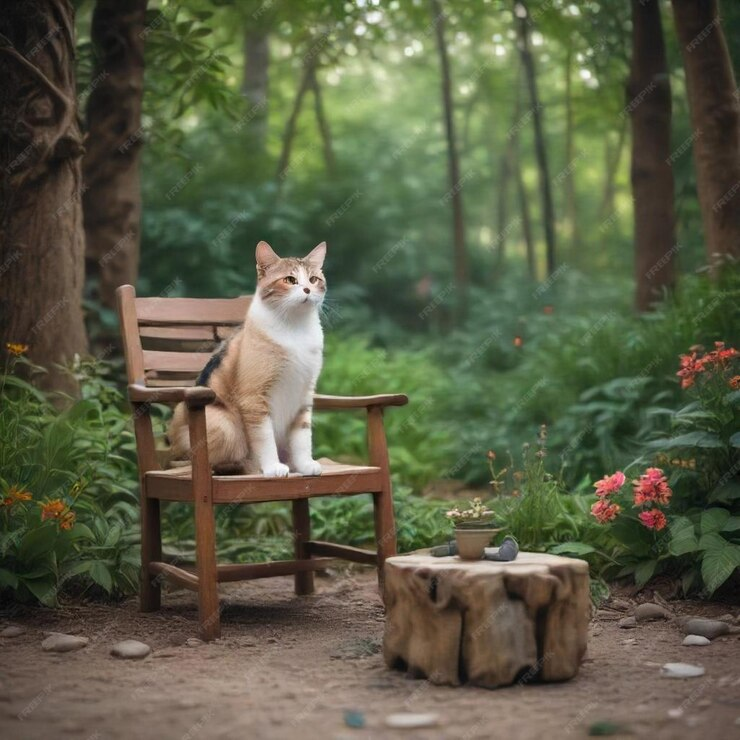

e:\T5-Vis\.venv\Lib\site-packages\transformers\generation\utils.py:1258: UserWarning:

Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.



Generated Caption: a cat sitting on a wooden chair in the woods


In [149]:
image_path = "example.jpg"  # Replace with your image file

# Generate caption for the image
caption = generate_caption(image_path)

# Display the caption in the notebook
print("Generated Caption:", caption)

Generated Caption: a cat sitting on a wooden chair in the woods


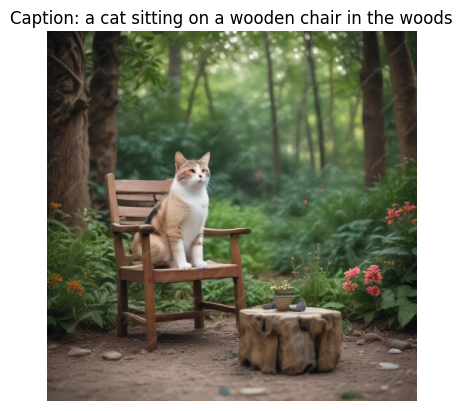

In [150]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

model.eval()

def generate_caption_and_attention(image_path):
    image = Image.open(image_path)
    inputs = processor(images=image, return_tensors="pt")
    
    outputs = model.generate(
        pixel_values=inputs.pixel_values,
        output_attentions=True,
        return_dict_in_generate=True
    )

    caption = processor.decode(outputs.sequences[0], skip_special_tokens=True)

    return caption, image


image_path = "example.jpg"

caption, image = generate_caption_and_attention(image_path)

print("Generated Caption:", caption)
plt.imshow(image)
plt.title(f"Caption: {caption}")
plt.axis('off')
plt.show()

C:\Users\arash\AppData\Local\Temp\ipykernel_51584\1737562357.py:8: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

C:\Users\arash\AppData\Local\Temp\ipykernel_51584\1737562357

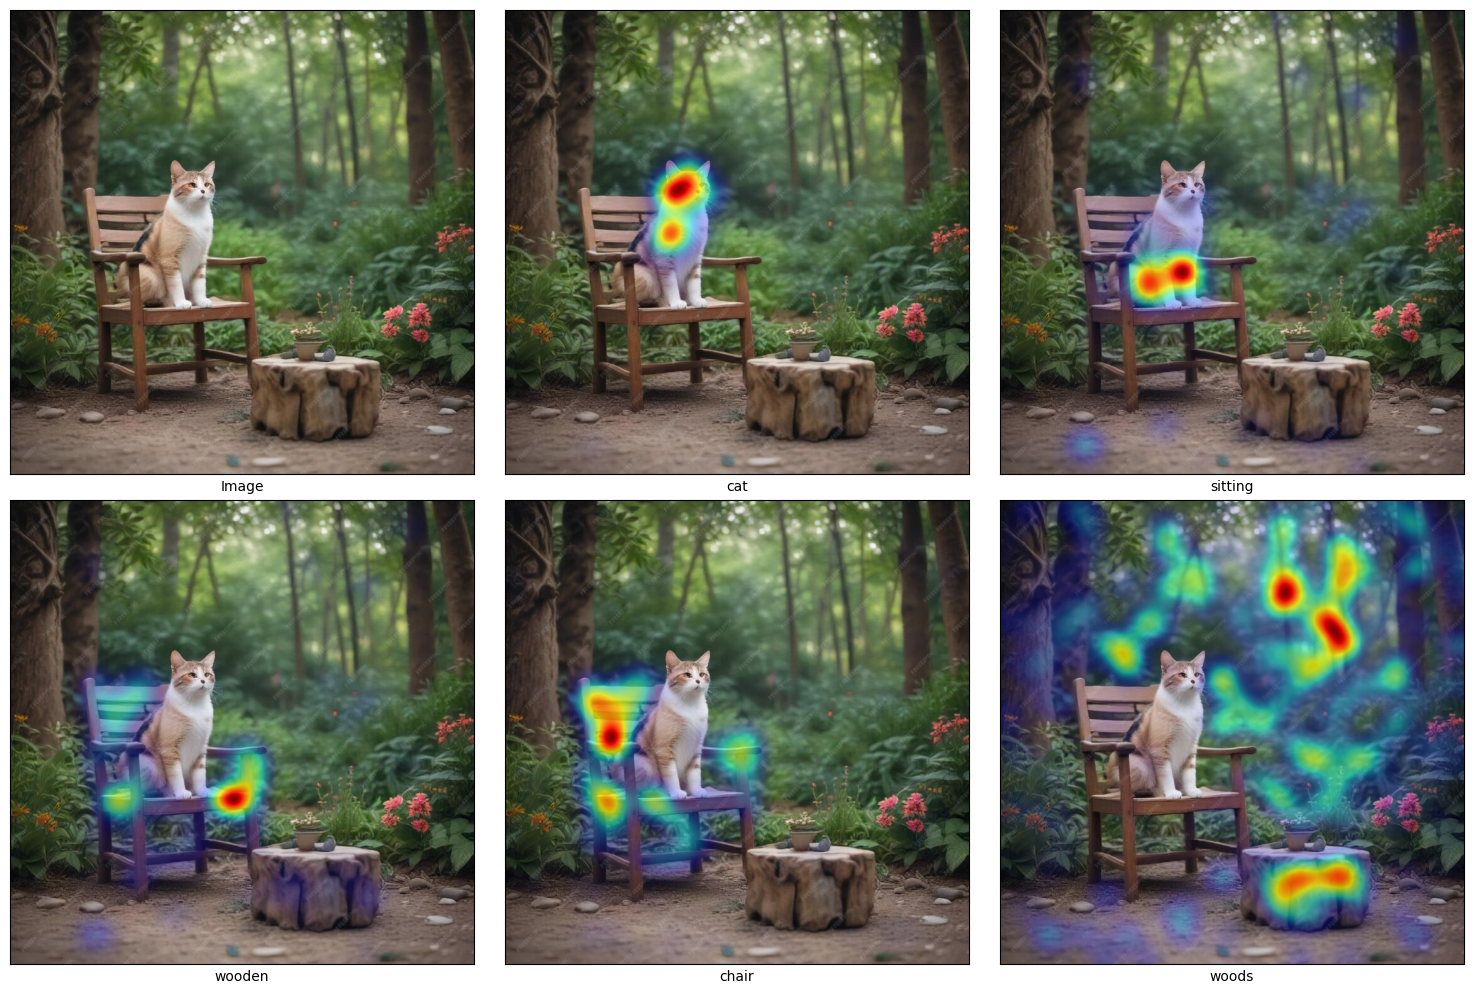

In [4]:
model_path = 'PTMs/refcoco.pth'
bert_config_path = 'configs/config_bert.json'
use_cuda = torch.cuda.is_available()

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = VLTransformerITM(text_encoder='bert-base-uncased', config_bert=bert_config_path)

checkpoint = torch.load(model_path, map_location='cpu')
model.load_state_dict(checkpoint, strict=False)
model.eval()

if use_cuda:
    model.cuda()

image_path = 'example.jpg'
image_pil = Image.open(image_path).convert('RGB')
image = transform(image_pil).unsqueeze(0)

caption = 'cat sitting wooden chair woods'
text = pre_caption(caption)
text_input = tokenizer(text, return_tensors="pt")

if use_cuda:
    image = image.cuda()
    text_input = text_input.to(image.device)

block_num = 8   
model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.save_attention = True

output = model(image, text_input)
loss = output[:, 1].sum()

model.zero_grad()
loss.backward()

with torch.no_grad():
    mask = text_input.attention_mask.view(text_input.attention_mask.size(0), 1, -1, 1, 1)

    grads = model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attn_gradients()
    cams = model.text_encoder.base_model.base_model.encoder.layer[block_num].crossattention.self.get_attention_map()

    cams = cams[:, :, :, 1:].reshape(image.size(0), 12, -1, 24, 24) * mask
    grads = grads[:, :, :, 1:].clamp(0).reshape(image.size(0), 12, -1, 24, 24) * mask

    gradcam = cams * grads
    gradcam = gradcam[0].mean(0).cpu().detach()


def get_att_map(img, att_map, blur=True, overlap=True):
    att_map -= att_map.min()
    if att_map.max() > 0:
        att_map /= att_map.max()
    att_map = skimage_transform.resize(att_map, img.shape[:2], order=3, mode='constant')
    if blur:
        att_map = filters.gaussian_filter(att_map, 0.02 * max(img.shape[:2]))
        att_map -= att_map.min()
        att_map /= att_map.max()
    cmap = plt.get_cmap('jet')
    att_map_v = cmap(att_map)
    att_map_v = np.delete(att_map_v, 3, 2)
    if overlap:
        att_map = (1 - att_map ** 0.7).reshape(att_map.shape + (1,)) * img + (att_map ** 0.7).reshape(
            att_map.shape + (1,)) * att_map_v
    return att_map


num_image = len(text_input.input_ids[0]) - 1
images_per_row = 3
num_rows = (num_image // images_per_row) + int(num_image % images_per_row > 0)

fig, ax = plt.subplots(num_rows, images_per_row, figsize=(15, 5 * num_rows))

rgb_image = cv2.imread(image_path)[:, :, ::-1]
rgb_image = np.float32(rgb_image) / 255

ax = ax.flatten()

ax[0].imshow(rgb_image)
ax[0].set_yticks([])
ax[0].set_xticks([])
ax[0].set_xlabel("Image")

sep_token_id = tokenizer.sep_token_id

for i, token_id in enumerate(text_input.input_ids[0][1:]):
    if token_id == sep_token_id:
        continue
    word = tokenizer.decode([token_id])
    gradcam_np = gradcam[i + 1].detach().cpu().numpy()
    gradcam_image = get_att_map(rgb_image, gradcam_np)
    ax[i + 1].imshow(gradcam_image)
    ax[i + 1].set_yticks([])
    ax[i + 1].set_xticks([])
    ax[i + 1].set_xlabel(word)

for j in range(i + 2, num_rows * images_per_row):
    ax[j].axis('off')

plt.tight_layout()
plt.show()

<div style="text-align: center;">
  <img src="./images/ViT.png" alt="ViT Image">
</div>

<div style="text-align: center;">
  <img src="./images/SED2AM/4.30pm.png" alt="ViT Image">
  <img src="./images/SED2AM/7am.png" alt="ViT Image">
</div>

<div style="text-align: center;">
  <img src="./images/SED2AM/Fig2a.png" alt="ViT Image" style="display: inline-block; margin-right: 10px;">
  <img src="./images/SED2AM/Fig2b.png" alt="ViT Image" style="display: inline-block; margin-right: 10px;">
  <img src="./images/SED2AM/Fig2c.png" alt="ViT Image" style="display: inline-block; margin-right: 10px;">
  <img src="./images/SED2AM/Fig2d.png" alt="ViT Image" style="display: inline-block; margin-right: 10px;">
  <img src="./images/SED2AM/Fig2e.png" alt="ViT Image" style="display: inline-block; margin-right: 10px;">
  <img src="./images/SED2AM/Fig2f.png" alt="ViT Image" style="display: inline-block; margin-right: 10px;">
  <img src="./images/SED2AM/Fig2g.png" alt="ViT Image" style="display: inline-block;">
</div>


In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
dataloader = DataLoader(cifar10_test, batch_size=8000, shuffle=False)

images, labels = next(iter(dataloader))
images = images.to(device)
labels = labels.cpu().numpy()

with torch.no_grad():
    image_features = model.encode_image(images)

image_features = image_features.cpu().numpy()
image_features = image_features / np.linalg.norm(image_features, axis=1, keepdims=True)

tsne = TSNE(n_components=2, random_state=1000)
image_features_2d = tsne.fit_transform(image_features)

class_names = cifar10_test.classes

df = pd.DataFrame({
    'x': image_features_2d[:, 0],
    'y': image_features_2d[:, 1],
    'label': labels,
    'class': [class_names[label] for label in labels]
})

fig = px.scatter(
    df, x='x', y='y', color='class',
    title="t-SNE visualization of CLIP image features (CIFAR-10)",
    labels={'color': 'Class'},
    color_discrete_sequence=[
        '#1f77b4',  # Blue
        '#ff7f0e',  # Orange
        '#2ca02c',  # Green
        '#d62728',  # Red
        '#9467bd',  # Purple
        '#8c564b',  # Brown
        '#e377c2',  # Pink
        '#7f7f7f',  # Gray
        '#bcbd22',  # Yellow-green
        '#17becf'   # Cyan
    ]
)

fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font_color='white',
    legend=dict(
        title="CIFAR-10 Classes",
        font=dict(size=12),
        bgcolor="rgba(0,0,0,0)",
        bordercolor="white",
        borderwidth=1
    ),
    title_font=dict(size=20),
    xaxis_title="t-SNE dimension 1",
    yaxis_title="t-SNE dimension 2",
    width=600,
    height=600
)

fig.update_traces(marker=dict(size=4))

fig.show()

Files already downloaded and verified


In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
dataloader = DataLoader(cifar10_test, batch_size=128, shuffle=False)

images, labels = next(iter(dataloader))
images = images.to(device)
labels = labels.cpu().numpy()

with torch.no_grad():
    image_features = model.encode_image(images)

selected_images = []
selected_labels = []
selected_indices = []

for i in range(10):
    class_indices = np.where(labels == i)[0]
    random_indices = random.sample(list(class_indices), 2)
    selected_images.append(images[random_indices])
    selected_labels.append(labels[random_indices])
    selected_indices.extend(random_indices)

selected_images = torch.cat(selected_images, dim=0)
selected_labels = np.concatenate(selected_labels)

with torch.no_grad():
    selected_features = model.encode_image(selected_images)

pca = PCA(n_components=3)
selected_features_3d = pca.fit_transform(selected_features.cpu().numpy())

class_names = cifar10_test.classes

colormap = plt.colormaps.get_cmap('tab10')

fig = go.Figure()

legend_class_added = set()

for i, (vec, label) in enumerate(zip(selected_features_3d, selected_labels)):
    class_color = mcolors.to_hex(colormap(label % 10))
    show_legend = label not in legend_class_added

    fig.add_trace(go.Scatter3d(
        x=[0, vec[0]], y=[0, vec[1]], z=[0, vec[2]],
        mode='markers',
        marker=dict(size=5, color=class_color),
        name=class_names[label],
        hoverinfo='text',
        hovertext=f'Class: {class_names[label]}',
        showlegend=show_legend
    ))

    fig.add_trace(go.Scatter3d(
        x=[0, vec[0]], y=[0, vec[1]], z=[0, vec[2]],
        mode='lines',
        line=dict(color=class_color, width=4),
        showlegend=False
    ))

    fig.add_trace(go.Cone(
        x=[vec[0]], y=[vec[1]], z=[vec[2]],
        u=[vec[0]], v=[vec[1]], w=[vec[2]],
        colorscale=[[0, class_color], [1, class_color]],
        showscale=False,
        sizemode="absolute",
        sizeref=0.5,
        anchor="tip",
        showlegend=False
    ))

    if show_legend:
        legend_class_added.add(label)

fig.update_layout(
    legend=dict(
        title='Class Colors',
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02,
        font=dict(size=10),
        bordercolor="gray",
        borderwidth=1,
        itemclick="toggleothers",
    ),
    scene=dict(
        xaxis_title='PCA Dimension 1',
        yaxis_title='PCA Dimension 2',
        zaxis_title='PCA Dimension 3',
        xaxis=dict(showgrid=True, gridcolor='gray', zeroline=False, gridwidth=2),
        yaxis=dict(showgrid=True, gridcolor='gray', zeroline=False, gridwidth=2),
        zaxis=dict(showgrid=True, gridcolor='gray', zeroline=False, gridwidth=2),
        bgcolor='black'
    ),
    title="3D Visualization of CLIP Feature Vectors with Hover Information",
    width=800,
    height=800,
    plot_bgcolor='black',
    paper_bgcolor='black',
    font_color='white',
    margin=dict(l=0, r=100, b=100, t=100),
)

fig.show()

Files already downloaded and verified
